In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics

%matplotlib inline

## Pre-Task: Describe the goals of your study

**Goal:** Your job is to perform the following tasks:

- Collect your data from an AWS PostgreSQL instance, import it into your local PostgreSQL database, and then import with Python
- Perform any necessary data wrangling in advance of building your model
- Create a logistic regression model to figure out the likelihood of a passenger's survival
- Gridsearch optimal parameters for the logistic regression model
- Create a kNN model and optimize it's parameters with gridsearch
- Examine and explain the confusion matrices and ROC curves
- Create a report of your findings and detail the accuracy and assumptions of your model
- [BONUS] Change the decision threshold for positive labels using predicted probabilities
- [BONUS] Examine precision-recall instead of accuracy/ROC curves
- [VERY BONUS] Construct decision tree classifiers and bagging classifiers on the data

**Pro Tip:** Here are some questions to keep in mind:

- What are we looking for? What is the hypothesis?
- How can we train the model?
- What is the overall goal of this research project you have been assigned?



VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)

pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)

name            Name

sex             Sex

age             Age

sibsp           Number of Siblings/Spouses Aboard

parch           Number of Parents/Children Aboard

ticket          Ticket Number

fare            Passenger Fare

cabin           Cabin

embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.

## Part 1: Aquire the Data

#### 1. Connect to the remote database

In [3]:
from sqlalchemy import create_engine
import pandas as pd

#postgres specifc syntax..

#pass database type,username,colon, password,@ host trying to connect to : port connecting/database name
engine = create_engine(INFO REMOVED AS REQUESTED)

# this stays the same...
pd.read_sql("SELECT * FROM pg_catalog.pg_tables WHERE schemaname='public'", con=engine)


#password: gastudents

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers
0,public,train,dsi,None,True,False,False
1,public,table1,dsi_student,None,True,False,False


In [4]:
import pandas as pd

In [5]:
a = """ SELECT * FROM train"""
df = pd.read_sql(a, con=engine)
#actually conver to a dataframe
df = pd.DataFrame(df)

#### 2. Query the database and aggregate the data

## Passenger Demographics

Socioeconomic Status 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

In [6]:
SES = """ SELECT DISTINCT "Pclass", COUNT("Pclass") from train
GROUP BY "Pclass" """

pd.read_sql(SES, con = engine)

,Pclass,count
0,1,216
1,3,491
2,2,184


In [7]:
#Total number of siblings and spouses 
SES_full_count = """ SELECT COUNT("Pclass") from train
"""

pd.read_sql(SES_full_count, con = engine)

,count
0,891


Gender

In [8]:
count_f = """ SELECT COUNT("Sex") as female FROM train WHERE "Sex" = 'female'""" 
pd.read_sql(count_f, con=engine)

,female
0,314


** 314 females **


In [9]:
count_male = """SELECT COUNT("Sex") as male from train 
WHERE "Sex" = 'male'"""



pd.read_sql(count_male, con=engine)

,male
0,577


** 577 males **

In [10]:
#Confirmaiton of absence of null values or values other than male or female

dist_sex = """SELECT DISTINCT "Sex"from train 
"""



pd.read_sql(dist_sex, con=engine)

,Sex
0,male
1,female


In [11]:
male_age = """SELECT ROUND(AVG("Age")) as Male_AVG, MIN("Age") as Male_Min, MAX("Age") Male_Max from train 
WHERE "Sex" = 'male' """ 

pd.read_sql(male_age, con = engine)

,male_avg,male_min,male_max
0,31.0,0.42,80.0


In [12]:
female_age = male_age = """SELECT ROUND(AVG("Age")) as female_AVG, MIN("Age") as female_Min, MAX("Age") female_Max from train 
WHERE "Sex" = 'female' """ 

pd.read_sql(male_age, con = engine)

,female_avg,female_min,female_max
0,28.0,0.75,63.0


In [13]:
#There are NaN values in the age column but could not figure out how to count them. Slacked David
#to get help with doing so 

Sibling: Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic 
Spouse: Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored) 

In [14]:
# Distinct values for number of spouses or sibilings per passenger
siblings_spouse_distinct = """ SELECT DISTINCT "SibSp" from train """

pd.read_sql(siblings_spouse_distinct, con = engine)

,SibSp
0,4
1,5
2,8
3,1
4,2
5,0
6,3


In [15]:
# number of male passengers with just 1 spouse of sibling on board
male_1 = """SELECT COUNT("SibSp") as Male_1_SibSp from train 
WHERE "Sex" = 'male' AND "SibSp" = 1 """

pd.read_sql(male_1, con = engine)

,male_1_sibsp
0,103


In [16]:
# number of female passengers with just 1 spouse of sibling on board
# number of male passengers with just 1 spouse of sibling on board
female_1 = """SELECT "Sex", COUNT("SibSp") as Number_1_SibSp from train 
WHERE "SibSp" = 1
GROUP BY "Sex" """

pd.read_sql(female_1, con = engine)

,Sex,number_1_sibsp
0,male,103
1,female,106


Parent: Mother or Father of Passenger Aboard Titanic Child: Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

0 = Nanny

In [17]:
#male and female passenges with accompanied by a Nanny and their average age

male_nanny_age = """ SELECT "Sex", "Parch", AVG("Age") from train
WHERE "Parch" = 0
GROUP BY "Sex","Parch" """ 

pd.read_sql(male_nanny_age, con = engine)


,Sex,Parch,avg
0,male,0,32.764946
1,female,0,30.767974


Convert Query Results to DataFrame

In [18]:
df.head(1)



,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,None,S


## Fare and Embarked information

In [19]:
mask_1 = df["Pclass"]== 1

In [20]:
df[mask_1].Fare.median()

60.287499999999994

In [21]:
df[mask_1].describe()
#class one min fare is 0
#class one max fare is 512.33
#class one average fare 84.15
# class one median fare is 60.00



,index,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,216.000000,216.000000,216.000000,216.0,186.000000,216.000000,216.000000,216.000000
mean,460.597222,461.597222,0.629630,1.0,38.233441,0.416667,0.356481,84.154687
std,246.737616,246.737616,0.484026,0.0,14.802856,0.611898,0.693997,78.380373
min,1.000000,2.000000,0.000000,1.0,0.920000,0.000000,0.000000,0.000000
25%,269.750000,270.750000,0.000000,1.0,27.000000,0.000000,0.000000,30.923950
50%,471.000000,472.000000,1.000000,1.0,37.000000,0.000000,0.000000,60.287500
75%,669.500000,670.500000,1.000000,1.0,49.000000,1.000000,0.000000,93.500000
max,889.000000,890.000000,1.000000,1.0,80.000000,3.000000,4.000000,512.329200


In [22]:
mask_2 = df["Pclass"]== 2

In [23]:
df[mask_2].Fare.median()

14.25

In [24]:
df[mask_2].describe()
#class one min fare is 0
#class one max fare is 73.50
#class one average fare 20.66
# class one median fare is 14.25

,index,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,184.000000,184.000000,184.000000,184.0,173.000000,184.000000,184.000000,184.000000
mean,444.956522,445.956522,0.472826,2.0,29.877630,0.402174,0.380435,20.662183
std,250.852161,250.852161,0.500623,0.0,14.001077,0.601633,0.690963,13.417399
min,9.000000,10.000000,0.000000,2.0,0.670000,0.000000,0.000000,0.000000
25%,233.500000,234.500000,0.000000,2.0,23.000000,0.000000,0.000000,13.000000
50%,434.500000,435.500000,0.000000,2.0,29.000000,0.000000,0.000000,14.250000
75%,667.000000,668.000000,1.000000,2.0,36.000000,1.000000,1.000000,26.000000
max,886.000000,887.000000,1.000000,2.0,70.000000,3.000000,3.000000,73.500000


In [25]:
mask_3 = df["Pclass"]== 3

In [26]:
df[mask_3].Fare.median()

8.05

In [27]:
df[mask_3].describe()
#class one min fare is 0
#class one max fare is 69.55
#class one average fare 13.67
# class one median fare is 8.05

,index,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,491.000000,491.000000,491.000000,491.0,355.000000,491.000000,491.000000,491.000000
mean,438.154786,439.154786,0.242363,3.0,25.140620,0.615071,0.393075,13.675550
std,264.441453,264.441453,0.428949,0.0,12.495398,1.374883,0.888861,11.778142
min,0.000000,1.000000,0.000000,3.0,0.420000,0.000000,0.000000,0.000000
25%,199.000000,200.000000,0.000000,3.0,18.000000,0.000000,0.000000,7.750000
50%,431.000000,432.000000,0.000000,3.0,24.000000,0.000000,0.000000,8.050000
75%,665.500000,666.500000,0.000000,3.0,32.000000,1.000000,0.000000,15.500000
max,890.000000,891.000000,1.000000,3.0,74.000000,8.000000,6.000000,69.550000


embarked Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [28]:
df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [29]:
df.head(1)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,None,S


In [30]:
# Assumed number of travelers in this dataset

In [31]:
passengers = df["PassengerId"].count()

In [32]:
Sib_Spouses = df.SibSp.sum()

In [33]:
Parent_Child_Nanny = df.Parch.sum()

In [34]:
Total_Travelers = passengers + Sib_Spouses + Parent_Child_Nanny
print Total_Travelers

1697


#### 5. What are the risks and assumptions of our data? 

sibsp Number of Siblings/Spouses Aboard

**It is impossible to distinguish what the value for SibSp represents exactly from this dataset alone. 
One might be able to make the assumption that a value of one is likely representative of a spouse.**

parch Number of Parents/Children Aboard

**It is impossibel to distinguish what the value of Parch represents exactly from this dataset alone. 
One could assume that if the passenger was under the age of 18 and had a 0 they were likely accompanied by a nanny.**



** It appears that all travelers on the ship were not classified as passnegers in this dataset. Therefore we must assume that those persons accounted for in the SibSp and Parch columns were on the Titantic. Additionaly, given the description below:**


  "-As well, some travelled with very close friends or neighbors in a village, however, the definitions do not support   
   such relations."
   
   **It appears that there are additionally travelers on the Titantic that were not documented in this dataset. Which likely means we do not have an accurate count of total number of passengers on the Titanic. **
  
  
    

## Part 2: Exploratory Data Analysis

#### 1. Describe the Data

In [35]:
df.corr()

,index,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
index,1.000000,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
PassengerId,1.000000,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


#### 2. Visualize the Data

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [37]:
df.dtypes

index            int64
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [38]:
female_mask = df["Sex"] == "female"
male_mask = df["Sex"] == "male"


## Count of Male and Female Passengers##
** Not representative of total travelers in the dataset**

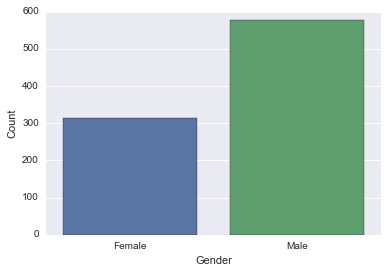

In [39]:
M = len(df[male_mask].Sex.values)
F = len(df[female_mask].Sex.values)

column_gender = ["Male","Female"]
rows_gender = [M,F]
index_gender = [0]

Male_Female_Hist = dict(zip(column_gender,rows_gender))
Male_Female_Hist = pd.DataFrame(Male_Female_Hist, index = index_gender)

Male_Female_Hist.head()

Male_Female_Hist_plot = sns.barplot(data = Male_Female_Hist )
sns.axlabel("Gender", "Count")

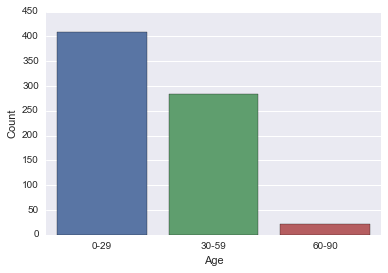

In [40]:
young_mask = df["Age"] <= 30
young_ages = len(df[young_mask].Age.values)

medium_mask = ((df["Age"] > 30) & (df["Age"] <= 60))
medium_ages  = len(df[medium_mask].Age.values)

seasoned_mask = df.Age > 60
seasoned_ages = len(df[seasoned_mask].Age.values)

age_keys = ["0-29", "30-59","60-90"]
age_values = [young_ages,medium_ages,seasoned_ages]
index_age = 0

age_dict = dict(zip(age_keys,age_values))
age_df = pd.DataFrame(age_dict, index = index_gender)

age_plot = sns.barplot(data = age_df)
sns.axlabel("Age", "Count")

In [41]:
# 177 null values in Age column
df.Age.isnull().sum()


177

## Part 3: Data Wrangling

#### 1. Create Dummy Variables for *Sex* 

In [42]:
# I will do this in patsy.

## Part 4: Logistic Regression and Model Validation

#### 1. Define the variables that we will use in our classification analysis

#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

#### 3. Conduct the logistic regression

In [43]:
df.columns

Index([u'index', u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex',
       u'Age', u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')

In [44]:
import numpy as np

In [45]:
import patsy 

formula1 = "Survived ~ Pclass + Age + C(Sex) + C(SibSp) + C(Parch) -1"

#format of variable assignment follows patsy formula above
Y1,X1 = patsy.dmatrices(formula1, data = df, return_type='dataframe')

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

In [47]:
logistic_1 = LogisticRegression()

In [48]:
np.mean(Y1)

Survived    0.406162
dtype: float64

In [49]:
y1 = np.ravel(Y1)


#### 6. Test the Model by introducing a *Test* or *Validaton* set 

In [50]:
# using this method as well so I can see my coefficients 
from sklearn.cross_validation import train_test_split
    

In [51]:
#split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20)

In [52]:
#fit
logistic_1.fit(X1_train,y1_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 7. Predict the class labels for the *Test* set

In [53]:
#predict
#pass x_test
predict_1 = logistic_1.predict(X1_test)
print predict_1

[ 0.  1.  1.  1.  0.  1.  0.  0.  1.  0.  1.  1.  1.  1.  1.  0.  1.  0.
  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.
  1.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  0.  0.  0.
  1.  0.  1.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  1.  1.  0.
  1.  0.  0.  0.  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  1.  0.  0.  1.  0.  1.  1.
  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.]


#### 8. Predict the class probabilities for the *Test* set

In [54]:
#probability of survival for first observation in test set
# %88.68 probability of death
# %11.31 probability of living
logistic_1.predict_proba(X1_test)[2]


array([ 0.15883048,  0.84116952])

#### 9. Evaluate the *Test* set

In [55]:
#score
#pass x_test and y_test
logistic_1.score(X1_test,y1_test)

0.82517482517482521

In [56]:
print X1_test.columns

Index([u'C(Sex)[female]', u'C(Sex)[male]', u'C(SibSp)[T.1]', u'C(SibSp)[T.2]',
       u'C(SibSp)[T.3]', u'C(SibSp)[T.4]', u'C(SibSp)[T.5]', u'C(SibSp)[T.8]',
       u'C(Parch)[T.1]', u'C(Parch)[T.2]', u'C(Parch)[T.3]', u'C(Parch)[T.4]',
       u'C(Parch)[T.5]', u'C(Parch)[T.6]', u'Pclass', u'Age'],
      dtype='object')


#### 4. Examine the coefficients to see our correlations

In [57]:
#coef
print logistic_1.coef_[0]
print logistic_1.intercept_

[ 2.16598099 -0.1759078   0.08946338 -0.16738949 -1.14228092 -1.00429801
 -0.67893072  0.          0.50999346  0.00256528  0.08892456 -0.76998903
 -0.34580926 -0.35238723 -1.10676475 -0.0272555 ]
[ 1.99007319]


#### 10. Cross validate the test set

In [58]:
#validation method one cross_val_score

validation_1 = cross_val_score(logistic_1, X1, y1, scoring=None, cv=5,verbose=1)
np.mean(validation_1)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


0.79136215896779283

#### 11. Check the Classification Report

In [59]:
from sklearn.metrics import classification_report
logistic_1_metrics = classification_report(predict_1,y1_test)
print logistic_1_metrics

             precision    recall  f1-score   support

        0.0       0.80      0.75      0.78        85
        1.0       0.67      0.72      0.69        58

avg / total       0.75      0.74      0.74       143



#### 12. What do the classification metrics tell us?

Precision – is the % of true positives your model predicts 

Recall – is the % instances that were captured by your model  

F1-Score – How well your model is doing over with recall and precision  

Support – number of observations for a value in the test set 

#### 13. Check the Confusion Matrix

In [60]:
 from sklearn.metrics import confusion_matrix

In [61]:
confusion_matrix_1 = confusion_matrix(y1_test,predict_1)
print confusion_matrix_1

[[64 16]
 [21 42]]


#### 14. What does the Confusion Matrix tell us? 

True positives = 78
False negatives = 9
False positives = 15
True negatives = 41

#### 15. Plot the ROC curve

In [62]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
% matplotlib inline

In [63]:
# passs ytest and predictions
#three variables are assigned values based on what is passed ot the roc_curve function
false_positive_rate, true_positive_rate, thresholds = roc_curve(y1_test, predict_1)


roc_auc = auc(false_positive_rate, true_positive_rate)

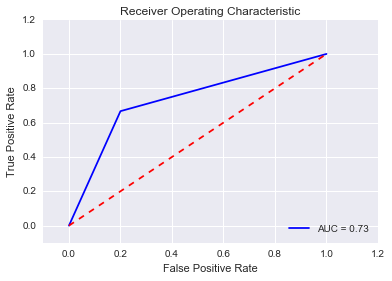

In [64]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 16. What does the ROC curve tell us?

Ratio of predicted values that were classified as positive and are actually positive, approx. 70%
Ratio of predicted values that were classified as postive by are not positive, approx 10%


## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

In [65]:
from sklearn.grid_search import GridSearchCV

In [66]:
search_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear'],
}



gs1 = GridSearchCV(logistic_1, search_parameters, cv = 5)

In [67]:
gs1.fit(X1,y1)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...6e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

In [68]:
print "Best Params:", gs1.best_params_
print "Best Score:", gs1.best_score_



Best Params: {'penalty': 'l2', 'C': 1.8420699693267164, 'solver': 'liblinear'}
Best Score: 0.798319327731


The score is better but just barely. 

pre-grid search score = 0.79136215896779283
grid-search score = 0.798319327731


#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

Lasso regression will shrink coefficients of predictors variables or zero them out in order to reduce sqaured error.

Ridge regression will shrink coefficients for being large but never zero them out in order to reduce squared error. 


#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?

Lasso is very useful when you have many feature options and you would like to reduce them.

Ridge regression will help minimize mutilcolinearlity and overfitting issues. 

#### 5. [BONUS] Explain how the regularization strength (C) modifies the regression loss function. Why do the Ridge and Lasso penalties have their respective effects on the coefficients?

#### 6.a. [BONUS] You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

## Part 6: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?

#### [BONUS] Why?

#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

#### 7. [BONUS] Plot the ROC curves for the optimized logistic regression model and the optimized kNN model on the same plot.

## Part 7: [BONUS] Precision-recall

#### 1. Gridsearch the same parameters for logistic regression but change the scoring function to 'average_precision'

`'average_precision'` will optimize parameters for area under the precision-recall curve instead of for accuracy.

#### 2. Examine the best parameters and score. Are they different than the logistic regression gridsearch in part 5?

#### 3. Create the confusion matrix. Is it different than when you optimized for the accuracy? If so, why would this be?

#### 4. Plot the precision-recall curve. What does this tell us as opposed to the ROC curve?

[See the sklearn plotting example here.](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

## Part 8: [VERY BONUS] Decision trees, ensembles, bagging

#### 1. Gridsearch a decision tree classifier model on the data, searching for optimal depth. Create a new decision tree model with the optimal parameters.

#### 2. Compare the performace of the decision tree model to the logistic regression and kNN models.

#### 3. Plot all three optimized models' ROC curves on the same plot. 

#### 4. Use sklearn's BaggingClassifier with the base estimator your optimized decision tree model. How does the performance compare to the single decision tree classifier?

#### 5. Gridsearch the optimal n_estimators, max_samples, and max_features for the bagging classifier.

#### 6. Create a bagging classifier model with the optimal parameters and compare it's performance to the other two models.